#  Set up colab gpu runtime environment

In [5]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Dataset

In [6]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (3/3), done.


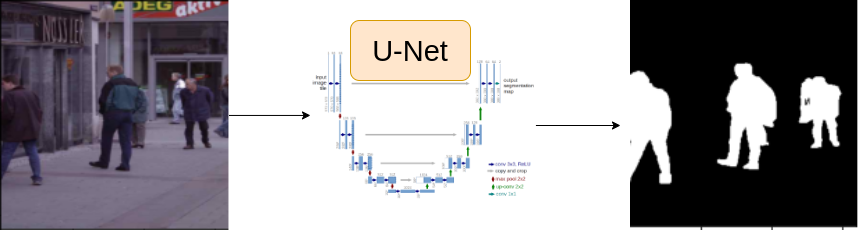

# Some Common Imports

In [7]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [8]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [9]:
csv_file='/content/Human-Segmentation-Dataset-master/train.csv'
data_dir='/content/'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs=25
lr=.003
image_size=320
batch_size=16

encoder='timm-efficientnet-b0'
weights='imagenet'

In [10]:
df=pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [11]:
image=cv2.imread(data_dir+df['images'][4])
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(data_dir+df['masks'][4],cv2.IMREAD_GRAYSCALE)/255.0



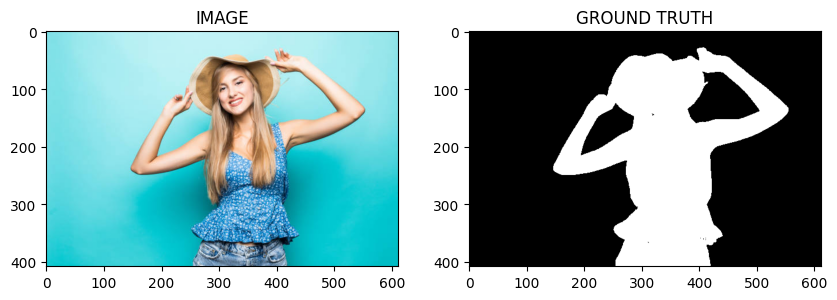

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [13]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Augmentation Functions

In [14]:
import albumentations as A

def get_train_aug():
    return A.Compose([
        A.Resize(image_size,image_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)
def get_valid_aug():
  return A.Compose([
      A.Resize(image_size,image_size)
  ], is_check_shapes=False)

# Custom Dataset

In [15]:
from torch.utils.data import Dataset,DataLoader

class SegmentaionData(Dataset):
  def __init__(self,df,augmentation):
    self.df=df
    self.augmentation=augmentation

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path) ## defalut BGR
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)  ## convert 3 channel to single

    if self.augmentation:
      aug=self.augmentation(image=image,mask=mask)
      image=aug['image']
      mask=aug['mask']

    image=np.transpose(image,(2,0,1)).astype(np.float32) # from (H, W, C) to (C, H, W)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)
    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask


In [16]:
trainset=SegmentaionData(train_df,get_train_aug())
validset=SegmentaionData(valid_df,get_valid_aug())

In [17]:
print(f"size of trainset:{len(trainset)}")
print(f"size of validset:{len(validset)}")

size of trainset:232
size of validset:58


In [18]:
idx=5
image,mask=trainset[idx]
print(image.shape,mask.shape)


torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


# Load dataset into batches


In [19]:
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader=DataLoader(validset,batch_size=batch_size)

In [20]:
print(f"Total number of batches in train loader:{len(trainloader)}")
print(f"Total number of batches in valid loader:{len(validloader)}")

Total number of batches in train loader:15
Total number of batches in valid loader:4


In [21]:
for image,mask in trainloader:
  break
print(image.shape,mask.shape)

torch.Size([16, 3, 320, 320]) torch.Size([16, 1, 320, 320])


# Segmentation Model

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [29]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,images,mask=None):
    logits=self.arc(images)
    if mask!=None:
      loss1=DiceLoss(mode='binary')(logits,mask)
      loss2=nn.BCEWithLogitsLoss()(logits,mask)
      return logits,loss1+loss2
    return logits

In [30]:
model=SegmentationModel()

In [34]:
model.to(device);

# Train and Validation Function

In [31]:
def train(model,data_loader,optimizer):
  model.train()
  total_loss=0.0
  for img,mask in data_loader:
    img=img.to(device)
    mask=mask.to(device)

    optimizer.zero_grad()
    logits,loss=model(img,mask)
    loss.backward()
    optimizer.step()

    total_loss=total_loss+loss.item()
  return total_loss/len(data_loader)



In [32]:
def val(model,data_loader):
  model.eval()
  total_loss=0.0
  with torch.no_grad():

    for img,mask in data_loader:
      img=img.to(device)
      mask=mask.to(device)

      logits,loss=model(img,mask)


      total_loss=total_loss+loss.item()
    return total_loss/len(data_loader)



# Model Train

In [36]:
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

best_valid_loss=np.Inf
for epoch in range(epochs):
  train_loss=train(model,trainloader,optimizer)
  valid_loss=val(model,validloader)
  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Model Saved")
    best_valid_loss=valid_loss
  print(f"Epoch : {epoch+1} Train loss : {train_loss} valid loss : {valid_loss}")

Model Saved
Epoch : 1 Train loss : 0.5041696151097615 valid loss : 0.37015051394701004
Epoch : 2 Train loss : 0.33082882265249886 valid loss : 0.4525677040219307
Model Saved
Epoch : 3 Train loss : 0.24283856948216756 valid loss : 0.24624865874648094
Epoch : 4 Train loss : 0.24847704370816548 valid loss : 0.2517167329788208
Epoch : 5 Train loss : 0.20901322066783906 valid loss : 0.2570621930062771
Model Saved
Epoch : 6 Train loss : 0.18774850368499757 valid loss : 0.18518589064478874
Epoch : 7 Train loss : 0.18101123571395875 valid loss : 0.2704983092844486
Epoch : 8 Train loss : 0.18309896886348725 valid loss : 0.20184211432933807
Epoch : 9 Train loss : 0.20340122282505035 valid loss : 0.29603011533617973
Epoch : 10 Train loss : 0.19871998131275176 valid loss : 0.3139784336090088
Epoch : 11 Train loss : 0.18700745354096096 valid loss : 0.2897142842411995
Epoch : 12 Train loss : 0.2287308802207311 valid loss : 0.2234630435705185
Epoch : 13 Train loss : 0.18113653659820556 valid loss : 0

# Inference

In [37]:
idx=20
model.load_state_dict(torch.load('/content/best_model.pt'))

image,mask=validset[idx]

logist_mask=model(image.to(device).unsqueeze(0)) # c h w ->1 c h w

pred_mask=torch.sigmoid(logist_mask)
pred_mask=(pred_mask>0.5)*1.0

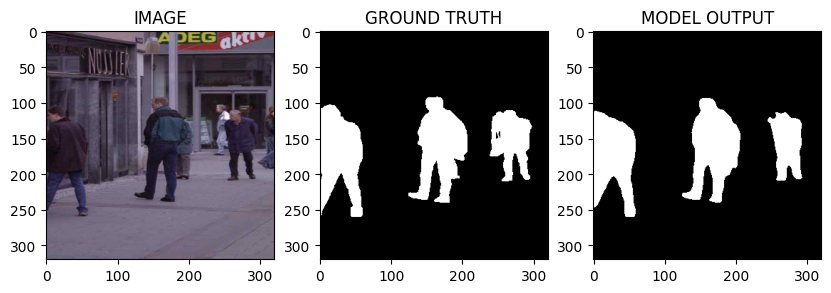

In [38]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))